In [26]:
import voxel3d as v3d
import plane_fitting as pf
import numpy as np
import pandas as pd
import importlib
importlib.reload(v3d)
importlib.reload(pf)

<module 'plane_fitting' from '/Users/matdou/Documents/Rough-Terrain-Planning/plane_fitting.py'>

In [2]:
# The following paths require the "testing data" to be at the same level as the script
prefix = '2022-07-22_flight__0254_1658494839082804823'
lidar_dir = 'goose_3d_val/lidar/val/2022-07-22_flight'
labels_dir = 'goose_3d_val/labels/val/2022-07-22_flight'
csv_file = 'goose_3d_val/goose_label_mapping.csv'

lidar_data, lidar_labels, label_metadata = pf.load_pointcloud_and_labels(prefix, lidar_dir, labels_dir, csv_file)


In [3]:
lidar_labels
a, b = (np.unique(lidar_labels, return_counts=True))
l = [(i,j) for i,j in zip(a,b)]
sum = 0
for p in l:
    if p[0] <1000:
        sum += p[1]
sum

200586

In [4]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('goose_3d_val/goose_label_mapping.csv')

# Create a dictionary mapping label_key to class_name
label_to_class = dict(zip(df['label_key'], df['class_name']))


In [5]:
#remove weird points that are not keys in the dictionary
lidar_labels = [label if label in label_to_class.keys() else 0 for label in lidar_labels]

In [6]:

pointcloud = lidar_data
labels = lidar_labels

In [7]:
voxel_labels, voxel_map, unique_voxel_labels = v3d.voxelize_point_cloud_2d(pointcloud, voxel_size=1)


In [8]:
# Preprocess voxels to map to majority labels and filter based on criteria
map_to_majority, voxel_pointclouds, voxel_ids_after_preprocessing = pf.preprocess_voxels(
    voxel_labels=voxel_labels,
    pointcloud=pointcloud,
    labels=labels,
    min_len=10,
    proportion_threshold=0.7
)


In [9]:
map_to_majority 
voxel_pointclouds 
voxel_ids_after_preprocessing

{120,
 166,
 250,
 251,
 256,
 259,
 262,
 263,
 313,
 333,
 334,
 344,
 345,
 354,
 365,
 415,
 435,
 436,
 441,
 442,
 456,
 472,
 510,
 511,
 525,
 527,
 536,
 538,
 543,
 544,
 550,
 551,
 557,
 558,
 574,
 608,
 624,
 625,
 647,
 648,
 665,
 682,
 683,
 687,
 731,
 753,
 790,
 795,
 804,
 811,
 812,
 813,
 818,
 819,
 820,
 831,
 839,
 849,
 865,
 866,
 870,
 871,
 876,
 878,
 879,
 880,
 881,
 882,
 885,
 898,
 899,
 900,
 907,
 908,
 909,
 928,
 929,
 933,
 934,
 955,
 956,
 957,
 959,
 965,
 966,
 967,
 991,
 999,
 1000,
 1007,
 1008,
 1040,
 1041,
 1049,
 1050,
 1051,
 1056,
 1058,
 1061,
 1062,
 1063,
 1064,
 1075,
 1082,
 1083,
 1084,
 1085,
 1091,
 1094,
 1095,
 1097,
 1098,
 1099,
 1100,
 1112,
 1113,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1132,
 1133,
 1134,
 1135,
 1136,
 1137,
 1146,
 1147,
 1148,
 1149,
 1150,
 1151,
 1152,
 1153,
 1154,
 1155,
 1167,
 1168,
 1169,
 1175,
 1183,
 1184,
 1185,
 1186,
 1187,
 1188,
 1197,
 1198,
 1204,
 1208,
 1227,
 1228,
 1229,
 12

In [25]:
for key, value in map_to_majority.items():
    try:
        print(key, label_to_class[value])
    except KeyError:
        print(key, value)

120 undefined
166 undefined
250 hedge
251 hedge
256 undefined
259 hedge
262 hedge
263 hedge
313 hedge
333 hedge
334 hedge
344 hedge
345 hedge
354 hedge
365 undefined
415 tree_crown
435 undefined
436 building
441 building
442 building
456 building
472 building
510 building
511 building
525 building
527 building
536 undefined
538 undefined
543 building
544 building
550 high_grass
551 fence
557 building
558 building
574 building
608 tree_crown
624 tree_crown
625 tree_crown
647 hedge
648 hedge
665 hedge
682 undefined
683 undefined
687 hedge
731 undefined
753 fence
790 hedge
795 hedge
804 fence
811 hedge
812 hedge
813 hedge
818 hedge
819 hedge
820 hedge
831 fence
839 hedge
849 hedge
865 tree_crown
866 fence
870 hedge
871 hedge
876 hedge
878 hedge
879 hedge
880 hedge
881 hedge
882 hedge
885 hedge
898 hedge
899 hedge
900 hedge
907 hedge
908 hedge
909 hedge
928 undefined
929 undefined
933 hedge
934 hedge
955 tree_crown
956 undefined
957 undefined
959 high_grass
965 hedge
966 hedge
967 hedge
99

In [16]:
# Analyze frequency of labels in map_to_majority
freq_df = pf.analyze_label_frequency(map_to_majority, label_to_class, sort_order='ascending')

# Print the frequency table
pf.print_label_frequency(freq_df)


Label_key, Class_name, Frequency
0 undefined 43
4 obstacle 4
8 ego_vehicle 2
17 bush 73
22 curb 1
23 asphalt 338
27 tree_crown 168
31 soil 9
38 building 14
41 fence 83
50 low_grass 193
51 high_grass 400
59 hedge 801


In [19]:
# Define the whitelist of class names to retain
whitelist = {'asphalt', 'low_grass', 'high_grass', 'hedge'}

# Filter voxels based on the whitelist
filtered_voxel_ids, labels_wl = pf.filter_voxels_by_whitelist(
    map_to_majority=map_to_majority,
    label_to_class=label_to_class,
    whitelist=whitelist
)

# Print the filtered voxel IDs and their class names
pf.print_filtered_voxels(
    filtered_voxel_ids=filtered_voxel_ids,
    map_to_majority=map_to_majority,
    label_to_class=label_to_class
)


INFO:plane_fitting:Number of labels in whitelist: 4
INFO:plane_fitting:Number of voxels after filtering by whitelist: 1732


Filtered Voxel IDs and their Class Names:
250 hedge
251 hedge
259 hedge
262 hedge
263 hedge
313 hedge
333 hedge
334 hedge
344 hedge
345 hedge
354 hedge
550 high_grass
647 hedge
648 hedge
665 hedge
687 hedge
790 hedge
795 hedge
811 hedge
812 hedge
813 hedge
818 hedge
819 hedge
820 hedge
839 hedge
849 hedge
870 hedge
871 hedge
876 hedge
878 hedge
879 hedge
880 hedge
881 hedge
882 hedge
885 hedge
898 hedge
899 hedge
900 hedge
907 hedge
908 hedge
909 hedge
933 hedge
934 hedge
959 high_grass
965 hedge
966 hedge
967 hedge
999 low_grass
1000 hedge
1007 hedge
1008 hedge
1040 hedge
1041 hedge
1049 hedge
1050 hedge
1051 hedge
1056 hedge
1058 low_grass
1075 hedge
1082 hedge
1083 hedge
1084 hedge
1085 hedge
1091 hedge
1094 high_grass
1095 high_grass
1112 hedge
1113 hedge
1117 hedge
1118 hedge
1119 hedge
1120 hedge
1121 hedge
1122 hedge
1146 hedge
1147 hedge
1148 hedge
1149 hedge
1150 hedge
1151 hedge
1152 hedge
1153 hedge
1154 hedge
1155 hedge
1175 low_grass
1183 hedge
1184 hedge
1185 hedge
1186 h

In [22]:
# Run plane fitting on the filtered voxels
plane_params = pf.run_plane_fitting_on_voxels(
    filtered_voxel_ids=filtered_voxel_ids,
    voxel_pointclouds=voxel_pointclouds
)


In [24]:
# Print the RMSE and class name for each voxel after plane fitting
pf.print_plane_fitting_results(
    plane_params=plane_params,
    map_to_majority=map_to_majority,
    label_to_class=label_to_class
)


Voxel ID: 250, RMSE: 0.1021, Class: hedge
Voxel ID: 251, RMSE: 0.1972, Class: hedge
Voxel ID: 259, RMSE: 0.1592, Class: hedge
Voxel ID: 262, RMSE: 0.0637, Class: hedge
Voxel ID: 263, RMSE: 0.0737, Class: hedge
Voxel ID: 313, RMSE: 0.1193, Class: hedge
Voxel ID: 333, RMSE: 0.1817, Class: hedge
Voxel ID: 334, RMSE: 0.1118, Class: hedge
Voxel ID: 344, RMSE: 0.1414, Class: hedge
Voxel ID: 345, RMSE: 0.1983, Class: hedge
Voxel ID: 354, RMSE: 0.1202, Class: hedge
Voxel ID: 550, RMSE: 0.0945, Class: high_grass
Voxel ID: 647, RMSE: 0.1401, Class: hedge
Voxel ID: 648, RMSE: 0.1611, Class: hedge
Voxel ID: 665, RMSE: 0.1312, Class: hedge
Voxel ID: 687, RMSE: 0.0804, Class: hedge
Voxel ID: 790, RMSE: 0.2225, Class: hedge
Voxel ID: 795, RMSE: 0.1275, Class: hedge
Voxel ID: 811, RMSE: 0.1633, Class: hedge
Voxel ID: 812, RMSE: 0.1058, Class: hedge
Voxel ID: 813, RMSE: 0.1748, Class: hedge
Voxel ID: 818, RMSE: 0.1838, Class: hedge
Voxel ID: 819, RMSE: 0.1240, Class: hedge
Voxel ID: 820, RMSE: 0.0945, 

-----

In [28]:
rmse_map = pf.aggregate_rmse_by_label(
    plane_params=plane_params,
    map_to_majority=map_to_majority
)

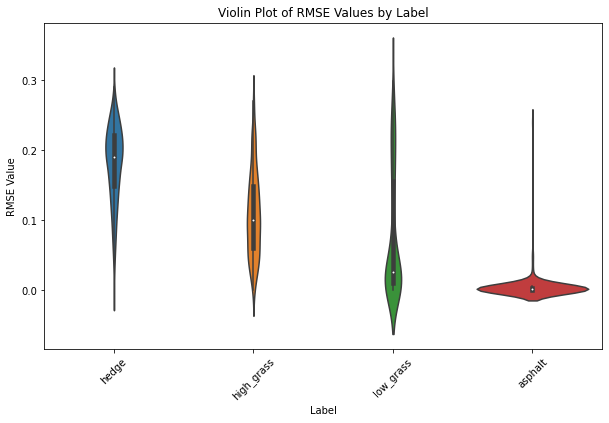

In [30]:
# Plot the violin plot for RMSE values by label
pf.plot_rmse_violin(
    rmse_map=rmse_map,
    label_to_class=label_to_class,
    figsize=(10, 6),
    title='Violin Plot of RMSE Values by Label'
)


In [37]:
rmse_avg = {}
for key, value in rmse_map.items():
    rmse_avg[key] = np.sum(value) / len(value)

In [38]:
rmse_avg

{59: 0.1814712282454537,
 51: 0.10914294332702376,
 50: 0.07622238244101456,
 23: 0.005620703732196968}

In [39]:
def find_closest_value_key(dictionary, value):
    closest = None
    for key in dictionary.keys():
        if closest is None or abs(dictionary[key] - value) < abs(dictionary[closest] - value):
            closest = key
    return closest


find_closest_value_key(rmse_avg, 0.05)

50

In [40]:
classification_results = {}

for vox_id in filtered_voxel_ids:
    rmse = plane_params[vox_id][1]
    closest_label = find_closest_value_key(rmse_avg, rmse)
    classification_results[vox_id] = closest_label
    

In [41]:
#compare classification_results and map_to_majority

In [45]:
# Create a dictionary to store the confusion matrix
confusion_matrix = {}
true_labels = []
predicted_labels = []
for vox_id in filtered_voxel_ids:
    true_label = map_to_majority[vox_id]
    predicted_label = classification_results[vox_id]
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)
    
    if true_label in confusion_matrix:
        if predicted_label in confusion_matrix[true_label]:
            confusion_matrix[true_label][predicted_label] += 1
        else:
            confusion_matrix[true_label][predicted_label] = 1
    else:
        confusion_matrix[true_label] = {predicted_label: 1}
    

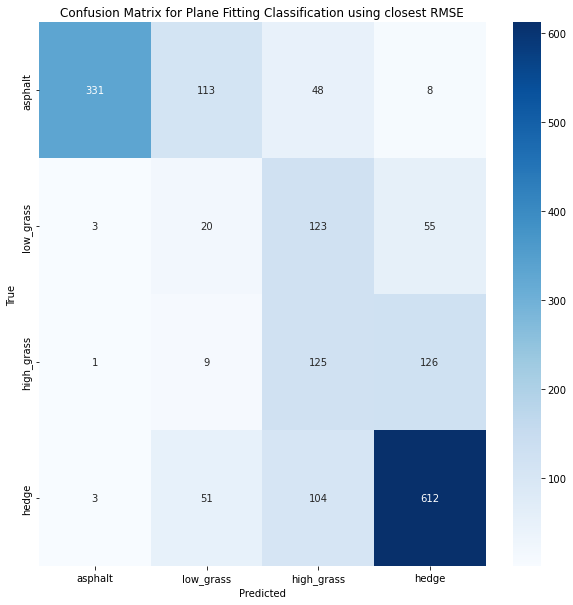

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

label_order = sorted(labels_wl)

df = pd.DataFrame(confusion_matrix, index=label_order, columns=label_order)

df.index = [label_to_class[label] for label in df.index]
df.columns = [label_to_class[label] for label in df.columns]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Plane Fitting Classification using closest RMSE')
plt.show()


In [47]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Example ground truth labels and predicted labels
y_true = true_labels
y_pred = predicted_labels
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute the F1 score
# You can pass y_true and y_pred directly, or compute F1 score for each class
f1_macro = f1_score(y_true, y_pred, average='macro')  # Average across classes (macro)
f1_micro = f1_score(y_true, y_pred, average='micro')  # Global F1 (micro)

print(f"F1 Score (Macro): {f1_macro}")
print(f"F1 Score (Micro): {f1_micro}")

F1 Score (Macro): 0.5122088452311686
F1 Score (Micro): 0.628175519630485


In [48]:
rmse_values = []
targets = []

# Populate rmse_values and targets from your plane_params and map_to_majority
for vox_id in filtered_voxel_ids:
    rmse = plane_params[vox_id][1]
    label = map_to_majority[vox_id]
    
    rmse_values.append(rmse)
    targets.append(label)

# Now you have two lists: rmse_values and targets


In [49]:
import numpy as np
from scipy.cluster.vq import kmeans, vq


rmse_values_array = np.array(rmse_values).reshape(-1, 1)
centroids, _ = kmeans(rmse_values_array, 4)
cluster_labels, _ = vq(rmse_values_array, centroids)

print("Cluster Labels:", cluster_labels)


Cluster Labels: [0 3 1 ... 0 0 0]


Cluster 0: 315 points
Cluster 1: 429 points
Cluster 2: 526 points
Cluster 3: 462 points


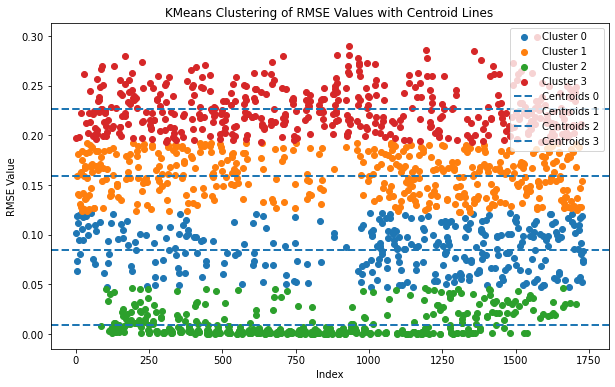

In [50]:
# Calculate statistics for each cluster
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

# Print statistics
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} points")

# Plot the RMSE values with clusters
plt.figure(figsize=(10, 6))

# Scatter plot with different colors for each cluster
for label in unique_labels:
    plt.scatter(np.arange(len(rmse_values_array))[cluster_labels == label], 
                rmse_values_array[cluster_labels == label], label=f"Cluster {label}")

# Plot centroids as vertical lines
for i, centroid in enumerate(centroids):
    plt.axhline(y=centroid, linestyle='--', linewidth=2, label=f'Centroids {i}')

plt.xlabel("Index")
plt.ylabel("RMSE Value")
plt.title("KMeans Clustering of RMSE Values with Centroid Lines")
plt.legend(loc='upper right')
plt.show()

In [51]:
np.shape(cluster_labels)

(1732,)

In [52]:
centroids

array([[0.08439687],
       [0.15929543],
       [0.00879   ],
       [0.22638967]])

In [53]:
# Flatten centroids to 1D array
centroids_flat = centroids.flatten()

# Get the sorted indices (descending order)
sorted_indices = np.argsort(-centroids_flat)

# Create a mapping from the rank (1st, 2nd, etc.) to the original index
rank_mapping = {rank + 1: sorted_indices[rank] for rank in range(len(sorted_indices))}



In [54]:

rmse_labels = list(rmse_avg.keys()) 
rmse_values = list(rmse_avg.values())

sorted_labels = [rmse_labels[rank_mapping[rank]] for rank in sorted(rank_mapping.keys())]

# Mapping of centroids to labels
cluster_labels_to_labels = {}
for i, label in enumerate(sorted_labels):
    cluster_labels_to_labels[i] = label


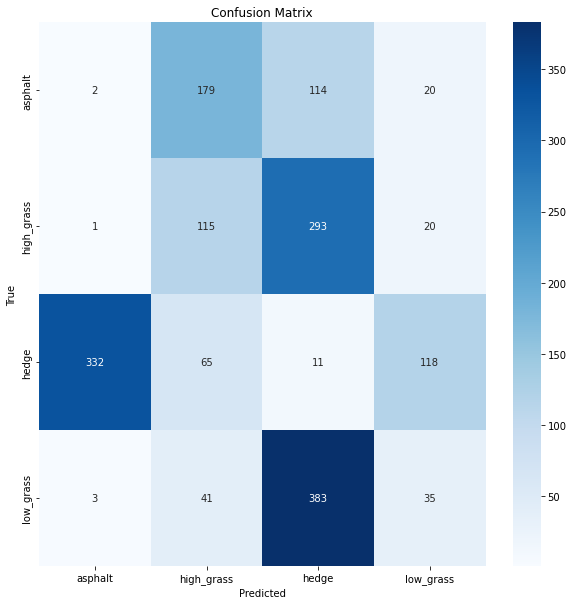

In [58]:
cluster_labels_mapped = [cluster_labels_to_labels[label] for label in cluster_labels]

# We need to compare cluster_labels_mapped with targets
# Calculate the confusion matrix
confusion_matrix_kmeans = {}
#label_order = sorted(labels_wl)
for true_label, predicted_label in zip(targets, cluster_labels_mapped):
    if true_label in confusion_matrix_kmeans:
        if predicted_label in confusion_matrix_kmeans[true_label]:
            confusion_matrix_kmeans[true_label][predicted_label] += 1
        else:
            confusion_matrix_kmeans[true_label][predicted_label] = 1
    else:
        confusion_matrix_kmeans[true_label] = {predicted_label: 1}
        
# Plot the confusion matrix
df = pd.DataFrame(confusion_matrix_kmeans, index=sorted_labels, columns=sorted_labels)

df.index = [label_to_class[label] for label in df.index]
df.columns = [label_to_class[label] for label in df.columns]



plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [56]:
predicted_label

23

In [57]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Example ground truth labels and predicted labels
y_true = targets
y_pred = cluster_labels_mapped

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute the F1 score
# You can pass y_true and y_pred directly, or compute F1 score for each class
f1_macro = f1_score(y_true, y_pred, average='macro')  # Average across classes (macro)
f1_micro = f1_score(y_true, y_pred, average='micro')  # Global F1 (micro)

print(f"F1 Score (Macro): {f1_macro}")
print(f"F1 Score (Micro): {f1_micro}")





F1 Score (Macro): 0.10175431359722768
F1 Score (Micro): 0.09411085450346422


In [33]:

import numpy as np
# Apply KMeans clustering (e.g., 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(rmse_values_array)

# Get cluster labels
cluster_labels = kmeans.predict(rmse_values_array)

# Map each voxel ID to its cluster label
classification_results = {vox_id: cluster_labels[i] for i, vox_id in enumerate(filtered_voxel_ids)}


In [34]:
rmse_values

array([0.10210022, 0.19718107, 0.15924021, ..., 0.08393369, 0.07250043,
       0.07494712])

In [31]:
from sklearn.cluster import KMeans
import numpy as np

# Prepare RMSE values
rmse_values = np.array([plane_params[vox_id][1] for vox_id in filtered_voxel_ids])

# Apply KMeans clustering (you can adjust the number of clusters, here we use 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(rmse_values.reshape(-1, 1))

# Get cluster labels for each RMSE value
cluster_labels = kmeans.predict(rmse_values.reshape(-1, 1))

# Map voxel IDs to their cluster labels
classification_results = {vox_id: cluster_labels[i] for i, vox_id in enumerate(filtered_voxel_ids)}


: 

: 

----

In [6]:
n_insufficient_voxels = 0
for i in np.unique(voxel_labels):
    if np.sum(voxel_labels == i) < 4:
        n_insufficient_voxels += 1

print(f"Number of voxels with less than 4 points: {n_insufficient_voxels}")
print(f"Proportion of voxels with less than 4 points: {n_insufficient_voxels / len(np.unique(voxel_labels))}")
#TODO : Maybe remove when len(points) == 3 because it's not enough to compute residuals

Number of voxels with less than 4 points: 2102
Proportion of voxels with less than 4 points: 0.358948087431694


In [7]:
pf.visualize_selected_points(pointcloud, voxel_labels)
#pf.visualize_selected_points(pointcloud, labels, label_metadata)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Compute residuals indifferently for all classes

In [8]:
voxel_planes, rmse = pf.compute_voxel_planes(pointcloud, voxel_labels)   

Error fitting plane for voxel 0: At least 3 points are required to fit a plane
Error fitting plane for voxel 1: At least 3 points are required to fit a plane
Error fitting plane for voxel 2: At least 3 points are required to fit a plane
Error fitting plane for voxel 3: At least 3 points are required to fit a plane
Error fitting plane for voxel 4: At least 3 points are required to fit a plane
Error fitting plane for voxel 5: At least 3 points are required to fit a plane
Error fitting plane for voxel 6: At least 3 points are required to fit a plane
Error fitting plane for voxel 7: At least 3 points are required to fit a plane
Error fitting plane for voxel 9: At least 3 points are required to fit a plane
Error fitting plane for voxel 10: At least 3 points are required to fit a plane
Error fitting plane for voxel 11: At least 3 points are required to fit a plane
Error fitting plane for voxel 12: At least 3 points are required to fit a plane
Error fitting plane for voxel 14: At least 3 poin

In [9]:
pf.plot_voxel_map(voxel_map, rmse, save_and_open=True, output_file='high_res_voxel_map.png', dpi=300)

# Per label residuals : Work In Progress

In [37]:
data = []
pointcloud = lidar_data

for i in np.unique(lidar_labels):

    # Filter the point cloud based on the current label
    filtered_pointcloud = pointcloud[lidar_labels == i]
    
    # Voxelize the point cloud
    voxel_labels_, voxel_map_ = v3d.voxelize_point_cloud_2d(filtered_pointcloud, voxel_size=30)
    
    # Compute the plane for each voxel and the associated RMSE
    voxel_planes_, rmse_ = pf.compute_voxel_planes(filtered_pointcloud, voxel_labels_)

    # Skip if no RMSE data is available
    if len(rmse_) == 0:
        continue
    
    # Compute the median RMSE for the current label
    median_rmse_ = np.median(list(rmse_.values()))
    
    total_points = 0
    weighted_rmse_sum = 0
    rmse_values = list(rmse_.values())
    
    # Compute RMSE statistics and total points
    for voxel_label, rmse_value in rmse_.items():
        num_points_in_voxel = np.sum(voxel_labels_ == voxel_label)
        weighted_rmse_sum += rmse_value * num_points_in_voxel
        total_points += num_points_in_voxel

    # Average RMSE weighted by the number of points in each voxel
    average_rmse_ = weighted_rmse_sum / total_points
    
    # Calculate additional statistics
    number_of_points_ = len(filtered_pointcloud)
    number_of_voxels_ = len(np.unique(voxel_labels_))
    rmse_sum_ = np.sum(rmse_values)
    rmse_std_ = np.std(rmse_values)
    max_rmse_voxel_ = max(rmse_, key=rmse_.get)  # Voxel with the highest RMSE
    min_rmse_voxel_ = min(rmse_, key=rmse_.get)  # Voxel with the lowest RMSE
    
    # Filter voxels with at least one point
    filtered_voxels_with_points_ = len([v for v in np.unique(voxel_labels_) if np.sum(voxel_labels_ == v) > 0])

    # Append results to the list
    data.append({
        'label': i,
        'RMSE': rmse_,
        'voxel_map': voxel_map_,
        'voxel_labels': voxel_labels_,
        'number_of_points': number_of_points_,
        'number_of_voxels': number_of_voxels_,
        'average_rmse': average_rmse_,
        'median_rmse': median_rmse_,
        'rmse_sum': rmse_sum_,
        'rmse_std': rmse_std_,
        'max_rmse_voxel': max_rmse_voxel_,
        'min_rmse_voxel': min_rmse_voxel_,
        'filtered_voxels_with_points': filtered_voxels_with_points_,
        'total_points_per_voxel': total_points,
        'pointcloud': filtered_pointcloud,
        'rmse_list': rmse_values,
    })

# Convert the list into a pandas DataFrame
df = pd.DataFrame(data)


Error fitting plane for voxel 0: At least 3 points are required to fit a plane
Error fitting plane for voxel 3: At least 3 points are required to fit a plane
Error fitting plane for voxel 4: At least 3 points are required to fit a plane
Error fitting plane for voxel 5: At least 3 points are required to fit a plane
Error fitting plane for voxel 2: At least 3 points are required to fit a plane
Error fitting plane for voxel 10: At least 3 points are required to fit a plane
Error fitting plane for voxel 15: At least 3 points are required to fit a plane
Error fitting plane for voxel 0: At least 3 points are required to fit a plane
Error fitting plane for voxel 6: At least 3 points are required to fit a plane
Error fitting plane for voxel 12: At least 3 points are required to fit a plane
Error fitting plane for voxel 14: At least 3 points are required to fit a plane
Error fitting plane for voxel 19: At least 3 points are required to fit a plane
Error fitting plane for voxel 22: At least 3 po

In [38]:
df

,label,RMSE,voxel_map,voxel_labels,number_of_points,number_of_voxels,average_rmse,median_rmse,rmse_sum,rmse_std,max_rmse_voxel,min_rmse_voxel,filtered_voxels_with_points,total_points_per_voxel,pointcloud,rmse_list
0,0,"{1: 0.174097705236871, 2: 0.02150416226412101}","{0: [-3, -1], 1: [-3, 0], 2: [-1, -3], 3: [-1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",26,6,0.143579,0.097801,0.195602,0.076297,1,2,6,20,"[[-79.88918, 0.50196517, -2.0083175, 54.0], [-...","[0.174097705236871, 0.02150416226412101]"
1,4,"{0: 0.026958166431660564, 1: 0.649213186120007...","{0: [-1, 1], 1: [2, 2], 2: [3, 2]}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",142,3,0.490889,0.026958,0.676171,0.299890,1,2,3,142,"[[-4.5191226, 31.912708, 0.24189891, 56.0], [-...","[0.026958166431660564, 0.6492131861200077, 6.4..."
2,8,"{0: 0.05686899374688219, 1: 0.016363416824533756}","{0: [-1, -1], 1: [-1, 0]}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",350,2,0.038699,0.036616,0.073232,0.020253,0,1,2,350,"[[-1.2069548, -0.1347418, -0.5663081, 20.0], [...","[0.05686899374688219, 0.016363416824533756]"
3,17,"{0: 0.285554322034761, 1: 0.8831766919267471, ...","{0: [-7, -3], 1: [-7, -2], 2: [-6, -3], 3: [-5...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",6835,17,0.810554,0.519747,9.541622,0.440729,12,16,17,6832,"[[-1.9534588, 13.260826, -0.5688288, 3.0], [-1...","[0.285554322034761, 0.8831766919267471, 0.8446..."
4,22,"{0: 0.0038521544770864953, 1: 0.02680559631892...","{0: [-1, -1], 1: [-1, 0]}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",60,2,0.013416,0.015329,0.030658,0.011477,1,0,2,60,"[[-5.5586696, 0.76836276, -1.9961847, 31.0], [...","[0.0038521544770864953, 0.026805596318925446]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,4653084,{0: 0.14867635312093236},"{0: [-1, 1]}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,1,0.148676,0.148676,0.148676,0.000000,0,0,1,38,"[[-5.3172107, 36.80787, 1.8514295, 21.0], [-5....",[0.14867635312093236]
83,4718620,{0: 0.09002421454063131},"{0: [0, 1]}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27,1,0.090024,0.090024,0.090024,0.000000,0,0,1,27,"[[2.8534408, 39.80755, 1.4494783, 14.0], [2.94...",[0.09002421454063131]
84,4784156,{0: 0.031710447543025724},"{0: [-2, 0]}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,1,0.031710,0.031710,0.031710,0.000000,0,0,1,17,"[[-43.401417, 23.476849, 4.169544, 37.0], [-43...",[0.031710447543025724]
85,4849692,{0: 0.058957110422644836},"{0: [-1, 1]}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",70,1,0.058957,0.058957,0.058957,0.000000,0,0,1,70,"[[-16.644602, 31.62279, 1.7790351, 14.0], [-16...",[0.058957110422644836]


In [11]:
# Assuming 'df' is your residuals DataFrame from previous computations
residuals_df = df

# Perform an inner join (merge) with label_metadata on 'label' (equivalent to 'label_key')
merged_df = pd.merge(label_metadata, residuals_df, left_on='label_key', right_on='label')

# Drop unnecessary columns 'has_instance' and 'hex'
merged_df = merged_df.drop(columns=['has_instance', 'hex'])

# Select and reorder the desired columns
merged_df = merged_df[['label', 'class_name', 'number_of_points', 'average_rmse', 'median_rmse', 'number_of_voxels', 
                       'rmse_std', 'rmse_sum', 'max_rmse_voxel', 'min_rmse_voxel']]

# Sort the merged dataframe by 'median_rmse' in ascending order
sorted_merged_df = merged_df.sort_values(by='median_rmse', ascending=True)

# Output the sorted DataFrame
print(sorted_merged_df)


    label   class_name  number_of_points  average_rmse  median_rmse  \
5      23      asphalt             11837      0.032811     0.014480   
4      22         curb                60      0.013416     0.015329   
1       4     obstacle               142      0.490889     0.026958   
2       8  ego_vehicle               350      0.038699     0.036616   
10     50    low_grass             10751      0.065931     0.052970   
9      41        fence             11253      0.058550     0.057733   
0       0    undefined                26      0.143579     0.097801   
8      38     building               431      1.323684     0.131808   
7      31         soil              1551      0.193333     0.166896   
11     51   high_grass             25143      0.336403     0.235861   
3      17         bush              6835      0.810554     0.519747   
12     59        hedge            116771      0.865780     0.680745   
6      27   tree_crown             15436      1.028776     0.809590   

    n

In [35]:
label =  22
asphalt_points = pointcloud[lidar_labels == label]
voxel_labels_, voxel_map_ = v3d.voxelize_point_cloud_2d(asphalt_points, voxel_size=1)
pf.visualize_selected_points(asphalt_points, voxel_labels_)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [31]:
df.label

0      0
1      4
2      8
3     17
4     22
5     23
6     27
7     31
8     38
9     41
10    50
11    51
12    59
Name: label, dtype: int32

In [ ]:
#pf.visualize_selected_points(lidar_data, lidar_labels, label_metadata)

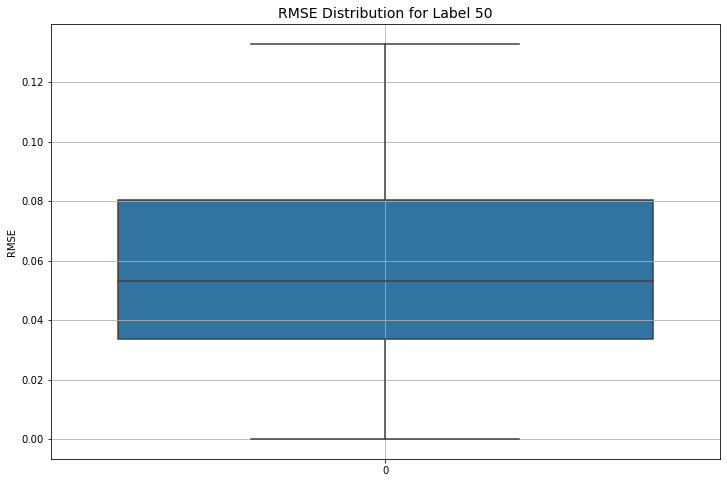

No RMSE data available for label 60.
No RMSE data available for label 70.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the list of labels you want to plot
specific_labels = [50, 60, 70]  # Replace with the labels you want to plot

# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each label in the list
for specific_label in specific_labels:
    # Filter the DataFrame for the specific label
    df_specific = df[df['label'] == specific_label]
    
    # Create a box plot for the RMSE distribution for this label
    rmse_values = list(df_specific['RMSE'].values[0].values()) if len(df_specific) > 0 else []
    
    if rmse_values:
        sns.boxplot(data=rmse_values)
        # Add titles and labels
        plt.title(f'RMSE Distribution for Label {specific_label}', fontsize=14)
        plt.ylabel('RMSE')
        plt.grid(True)
        plt.show()
    else:
        print(f"No RMSE data available for label {specific_label}.")


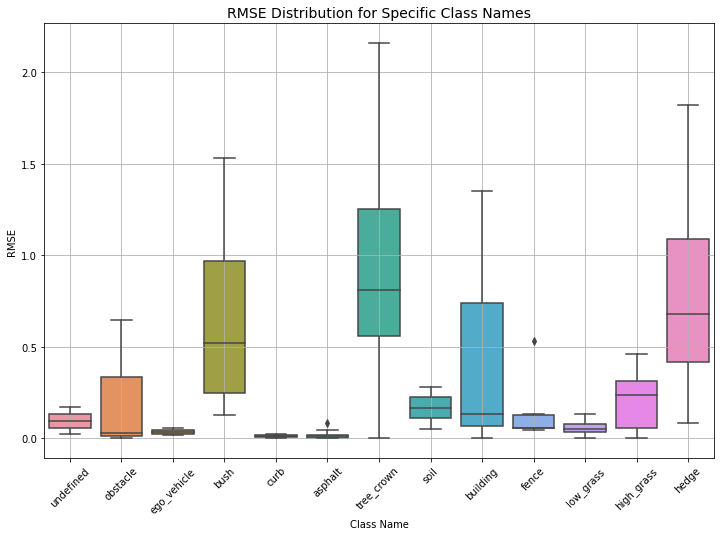

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
merged_df = pd.merge(label_metadata, df, left_on='label_key', right_on='label')
# Input your specific list of labels here
specific_labels = [0,1,2,4,8,17,22,23,27,31,38,41,50,51,59]  # Replace with the labels you want to plot

# Create an empty list to store RMSE values along with their corresponding labels and class names
rmse_data = []

# Loop through the DataFrame and collect RMSE values for the specific labels
for _, row in merged_df.iterrows():
    if row['label'] in specific_labels:  # Filter for the specific labels
        for rmse_value in row['rmse_list']:
            rmse_data.append({
                'class_name': row['class_name'],  # Store the class_name instead of the label
                'RMSE': rmse_value
            })

# Convert the list to a DataFrame
rmse_df = pd.DataFrame(rmse_data)

# Check if rmse_df is not empty before plotting
if not rmse_df.empty:
    # Create the box plot for the specific labels
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='class_name', y='RMSE', data=rmse_df)

    # Add titles and labels
    plt.title('RMSE Distribution for Specific Class Names', fontsize=14)
    plt.xlabel('Class Name')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.grid(True)
    plt.show()
else:
    print("No data available for the specified labels.")
